In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

2024-04-16 11:15:25.579020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Batching dataset elements

### Simple batching

The simplest form of batching stacks `n` consecutive elements of a dataset into a single element. The [`Dataset.batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) transformation does exactly this, with the same constraints as the [`tf.stack()`](https://www.tensorflow.org/api_docs/python/tf/stack) operator, applied to each component of the elements: i.e., for each component *i*, all elements must have a tensor of the exact same shape.

In [2]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


2024-04-16 11:15:28.960381: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 11:15:28.964079: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 11:15:28.964182: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

While [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) tries to propagate shape information, the default settings of [`Dataset.batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) result in an unknown batch size because the last batch may not be full. Note the `None`s in the shape:

In [3]:
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Use the `drop_remainder` argument to ignore that last batch, and get full shape propagation:

In [4]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(7,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.int64, name=None))>

### Batching tensors with padding

The above recipe works for tensors that all have the same size. However, many models (including sequence models) work with input data that can have varying size (for example, sequences of different lengths). To handle this case, the [`Dataset.padded_batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch) transformation enables you to batch tensors of different shapes by specifying one or more dimensions in which they may be padded.

In [5]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()

[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



2024-04-16 11:34:05.397951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The [`Dataset.padded_batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch) transformation allows you to set different padding for each dimension of each component, and it may be variable-length (signified by `None` in the example above) or constant-length. It is also possible to override the padding value, which defaults to 0.

# Training workflows

### Processing multiple epochs

The [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API offers two main ways to process multiple epochs of the same data.

The simplest way to iterate over a dataset in multiple epochs is to use the [`Dataset.repeat()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat) transformation. First, create a dataset of titanic data:

In [6]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

30874/30874 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
df = pd.read_csv(titanic_file)
df.head(3)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y


In [31]:
df.shape[0] / 128

4.8984375

meaning that it can produce a size of 4.9 batches without repeat

In [7]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

Applying the [`Dataset.repeat()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat) transformation with no arguments will repeat the input indefinitely.

The [`Dataset.repeat`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat) transformation concatenates its arguments without signaling the end of one epoch and the beginning of the next epoch. Because of this a [`Dataset.batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) applied after [`Dataset.repeat`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat) will yield batches that straddle epoch boundaries

2024-04-16 21:52:01.134125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


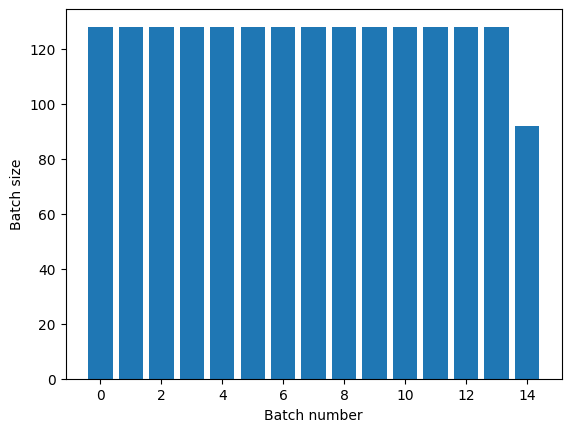

In [8]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

If you need clear epoch separation, put [`Dataset.batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) before the repeat:

2024-04-16 21:55:26.783911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


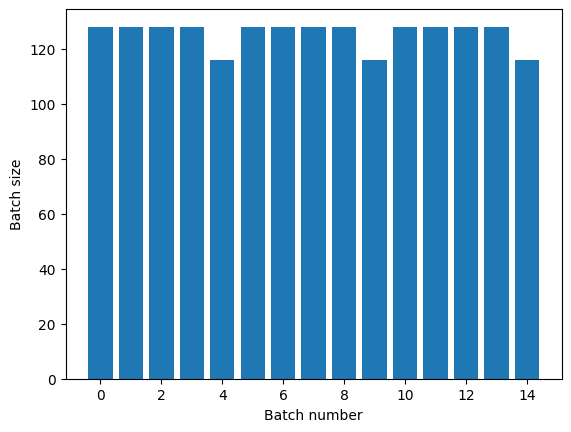

In [10]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

If you would like to perform a custom computation (for example, to collect statistics) at the end of each epoch then it's simplest to restart the dataset iteration on each epoch:

In [11]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


2024-04-16 21:57:00.172074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-16 21:57:00.178153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-16 21:57:00.182236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Randomly shuffling input data

The [`Dataset.shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) transformation maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer.

**Note:** While large buffer_sizes shuffle more thoroughly, they can take a lot of memory, and significant time to fill. Consider using [`Dataset.interleave`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#interleave) across files if this becomes a problem.

Add an index to the dataset so you can see the effect:

***JY NOTE*** Every time a batch of data was consumed from the buffer, the buffer is filled with the next new data from the full dataset. After that, a new batch of data selected randomly from the buffer.

In [33]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.Dataset.counter()

dataset = tf.data.Dataset.zip((counter, lines))

In [34]:
ba_dataset = dataset.batch(20)

In [45]:
for n, line_batch in ba_dataset.take(2):
    print(n.numpy())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


2024-04-16 22:37:38.637040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
sh_dataset = dataset.shuffle(buffer_size=100)
sh_ba_dataset = sh_dataset.batch(20)
sh_ba_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

Since the `buffer_size` is 100, and the batch size is 20, the first batch contains no elements with an index over 120.

In [41]:
n,line_batch = next(iter(sh_ba_dataset))
print(n.numpy())

[ 32  52  63   2 103  36  82  79  60  10  74  38  67  43  78  15  89 105
  56 108]


In [47]:
for n, line_batch in sh_ba_dataset.take(5):
    print(n.numpy())

[ 36   3  27  23  78   5  61  90  17 105 106   4 103  64  43  15  89  72
  19  99]
[ 46 117  37  33 107  79  12  88 102 113  48  87  83 100   9 128  53  60
  82 109]
[ 70  57  13 104 110  47  41 122  11  98 131   8 145  50  84   0  52  39
 149 127]
[129 156 133 148  31  65 142  26 116  29 139  34 125  56  18 115 174 146
   7  76]
[177  16  66 159 121 124  71  73  44   1 111  10 151  68  92 189  32 112
 140  77]


2024-04-16 22:38:13.194883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


---
#### repeat and shuffle

As with [`Dataset.batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the order relative to [`Dataset.repeat`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat) matters.

[`Dataset.shuffle`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next:

In [42]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[470 612 531 622 480 577 549 578 625 624]
[533 523 532 566 610 592 570 124 627 432]
[572 504 510 585 598 586 535 591]
[51 38 60 45 28 56 78 15 77 37]
[ 87   7  11  93 110  55 106  70 103  22]


2024-04-16 22:34:29.670297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-04-16 22:34:49.705473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


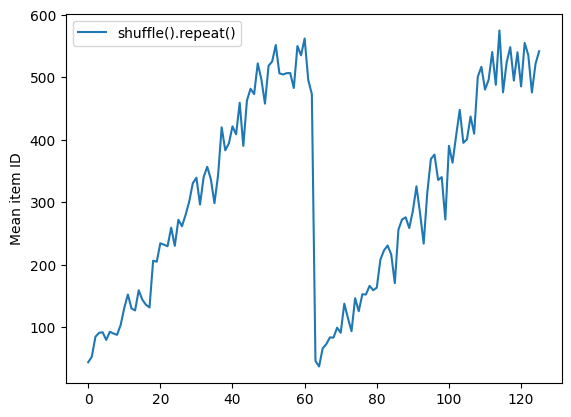

In [43]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

In [44]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[428 608 323   3  24  13   5 519  19 574]
[457  10 609 607 446 421 616 506  28  22]
[  0  18 523  36 552 577   6 277  31 307]
[626  34 561  38 465 622  33 543 524  54]
[612 360  25 306   8  41 578 559 570 560]
[ 20  51  35 545 196  53 598  68  66  16]
[ 14 527 464 451  83  73  29 535  87 508]
[531  69   2  64  37  79  17  86  30 556]
[476 470  82  94  50  42 623  92  15  39]
[575  81   1 498 565 105  49 606  47  48]
[ 62 107  23 104 115 592  70 332 617  57]
[114  90 120  97 625 136  75  59 108 134]
[ 21 596  88  98  74  32 127 141 583 597]
[ 58 135 109 125  40 586 152  65  99 140]
[147 103 148 138 202 111  67  78 611 106]


2024-04-16 22:34:59.370508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-04-16 22:38:24.189893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


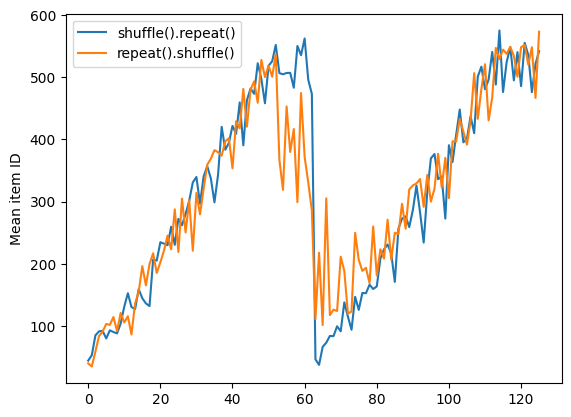

In [48]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()